# Autoencoder
Here we will code an autoencoder for denoising MNIST digits.

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

from res.plot_lib import plot_data, plot_data_np, plot_model, set_default
set_default()

C:\miniconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load MNIST dataset

# TRAIN dataset
# Pytorch already has some datasets available for downlaod
train_dataset = datasets.MNIST('../data', train=True, download=True, 
                # transforms that we want to apply when iterating the dataset
                   transform=transforms.ToTensor())

# The datasoar will iterate through the dataset and load the data in memory
train_loader = torch.utils.data.DataLoader(
                        train_dataset,
                        batch_size=64, shuffle=True)

# TEST dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
                   transform=transforms.ToTensor()),
                    batch_size=1000, shuffle=True)

In [3]:
print(len(train_dataset), len(train_loader))

60000 938


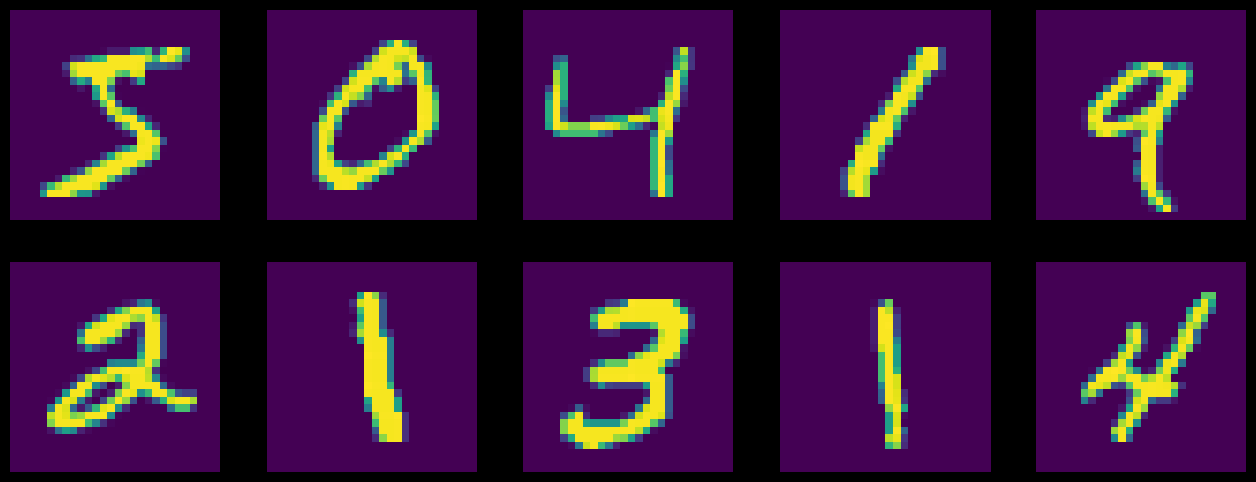

In [4]:
# show some images
to_pil = transforms.ToPILImage()
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i) # load one image
    plt.imshow(to_pil(image))
    plt.axis('off')

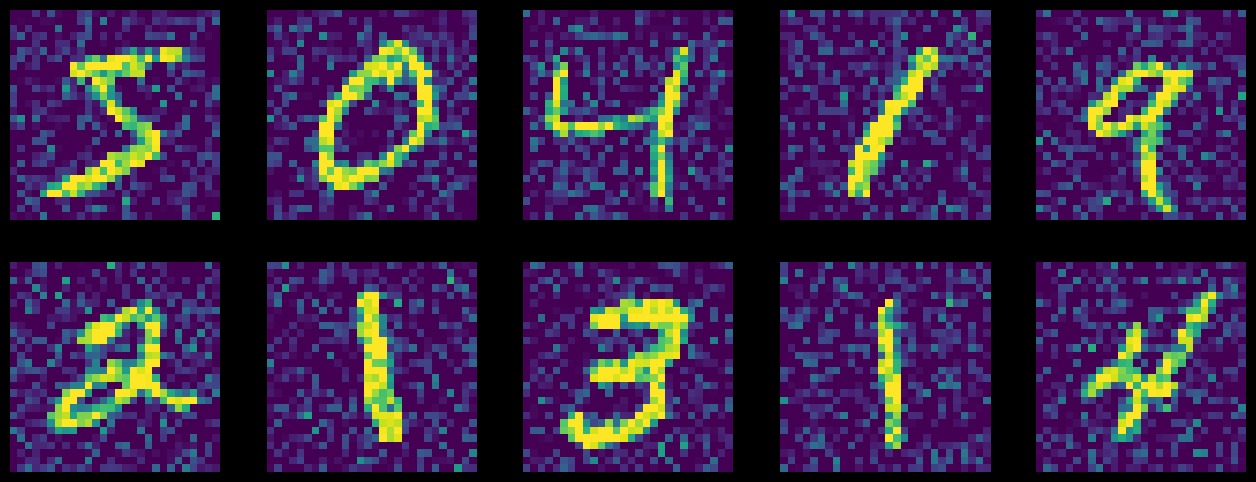

In [7]:
# Add noise to MNIST digits
noise_factor = 0.2

plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    # define noise
    noise = torch.randn(1,28,28)
    
    image, _ = train_loader.dataset.__getitem__(i) # load one image
    
    image = (image + noise*noise_factor)
    imge = image.clamp_(0, 1)
    plt.imshow(to_pil(image))
    plt.axis('off')

In [8]:
# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
# Let's define our AE for denoising

# define the NN architecture
class AE_Denoiser(nn.Module):
    def __init__(self, latent_size = 64):
        super(AE_Denoiser, self).__init__()
        
        self.latent_size = latent_size
        
        ## encoder ##
        # x.size() = bs, 1, 28, 28 -> bs, latent_size
        self.Encoder = nn.Sequential(nn.Conv2d(1, 16, 4, stride = 2, padding=1), #16x14x14   [(W−K+2P)/S]+1
                                        nn.ReLU(),
                                        nn.Conv2d(16, 32, 4, stride = 2, padding=1), #32x7x7
                                        nn.ReLU(),
                                        nn.Conv2d(32, 64, 3, stride = 2, padding=1), #64x4x4
                                        nn.ReLU(),
                                        nn.Conv2d(64, self.latent_size, 4, stride = 1, padding=0), #64x1x1
                                        nn.ReLU(), 
                                        nn.Flatten())  #latent_size
        
        ## decoder ##
        # x.size() = bs, latent_size, 1, 1 -> bs, 1, 28, 28
        self.Decoder = nn.Sequential(nn.ConvTranspose2d( self.latent_size, 64, 4, 1, 0), #4x4  (W - 1)S -2P + (K - 1) + 1
                                    nn.ReLU(),
                                    nn.ConvTranspose2d( 64, 32, 3, 2, 1), #7x7
                                    nn.ReLU(),
                                    nn.ConvTranspose2d( 32, 16, 4, 2, 1), #14x14
                                    nn.ReLU(),
                                    nn.ConvTranspose2d( 16, 1, 4, 2, 1), #28x28
                                    nn.Sigmoid())


    def forward(self, x):
        ## encode ##
        latent = self.Encoder(x)  # compressed representation
        
        ## decode ##
        x = self.Decoder(latent.view(x.size(0),self.latent_size,1,1))
        
        return x, latent

    
ae = AE_Denoiser().to(device)
print(ae)

AE_Denoiser(
  (Encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (Decoder): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): Sigmoid()
  )
)


In [10]:
# define Optimizer and Loss
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)

# as loss lets use MSE
mse_loss = nn.MSELoss()

In [11]:
# TRAIN!!!

ae.train()

for epoch in range(3):
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data = data.to(device)
        
        # add noise pixels
        noise = torch.randn(data.size(0),1,28,28).to(device)
        noise_data = (data + noise*noise_factor).clamp_(0, 1)
        
        optimizer.zero_grad()
        output, latent = ae(noise_data)
        # loss between the output of AE and original data withoud noise
        loss = mse_loss(output, data)
        loss.backward()
        optimizer.step()
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    torch.save(ae.state_dict(), "./res/ae.pth")

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.217945
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.065339
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.038880
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.028456
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.023230
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.018847
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.016621
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.016027
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.011782
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.011272
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.010256
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.010352
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.010783
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.011088
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.009519


In [12]:
# TEST
image, target = next(iter(test_loader)) # load one batch
image = image.to(device)
noise = torch.randn(image.size(0),1,28,28).to(device)
noise_image = (image + noise*noise_factor).clamp_(0, 1)

ae.eval()
with torch.no_grad():
    denoised_out, latent = ae(noise_image)

(-0.5, 241.5, 31.5, -0.5)

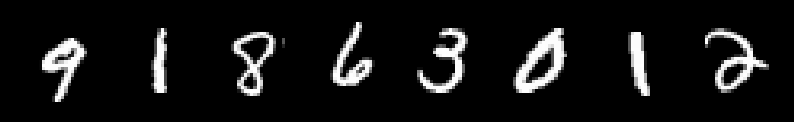

In [13]:
image_grid = torchvision.utils.make_grid(image[:8])
plt.imshow(to_pil(image_grid))
plt.axis("off")

(-0.5, 241.5, 31.5, -0.5)

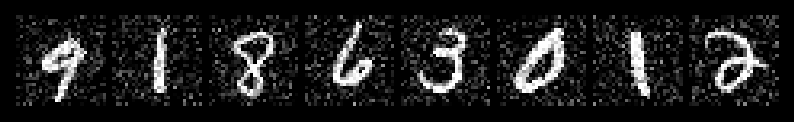

In [14]:
image_grid = torchvision.utils.make_grid(noise_image[:8])
plt.imshow(to_pil(image_grid))
plt.axis("off")

(-0.5, 241.5, 31.5, -0.5)

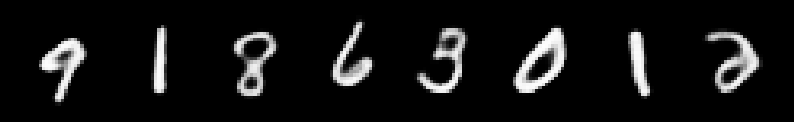

In [15]:
image_grid = torchvision.utils.make_grid(denoised_out[:8])
plt.imshow(to_pil(image_grid))
plt.axis("off")

In [16]:
print(latent.size())

torch.Size([1000, 64])


### T-SNE
t-SNE is a tool to visualize high-dimensional data:
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

We just need to specify to how many component we want to reduce our high dimentional space. In this case we want to pass from a latent code of dimension <code>latent_size</code> to a latent code of dimension 2.

In [17]:
# Let's visualize latent space
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(latent.detach().cpu().numpy())

In [18]:
print(tsne.shape, target.shape)

(1000, 2) torch.Size([1000])


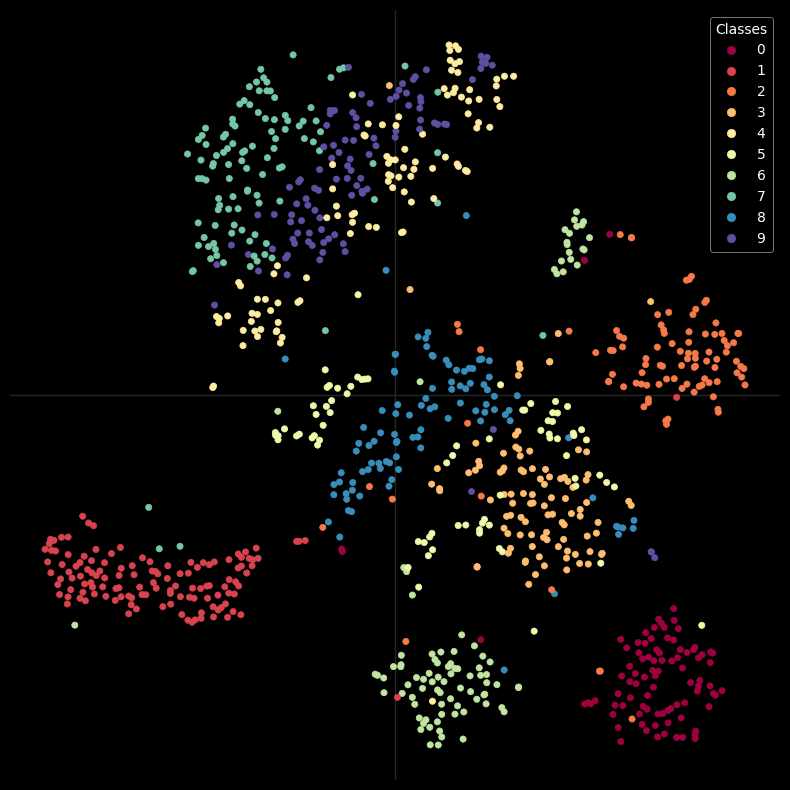

In [19]:
# plot
# scale and move the coordinates so they fit [-1; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [-1; 1] by dividing by its range
    return 2*(starts_from_zero / value_range) - 1

# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

tsne[:, 0] = tx
tsne[:, 1] = ty

plot_data_np(tsne, target.numpy(), legend = True)

In [20]:
tsne_3d = TSNE(n_components=3).fit_transform(latent.detach().cpu().numpy())

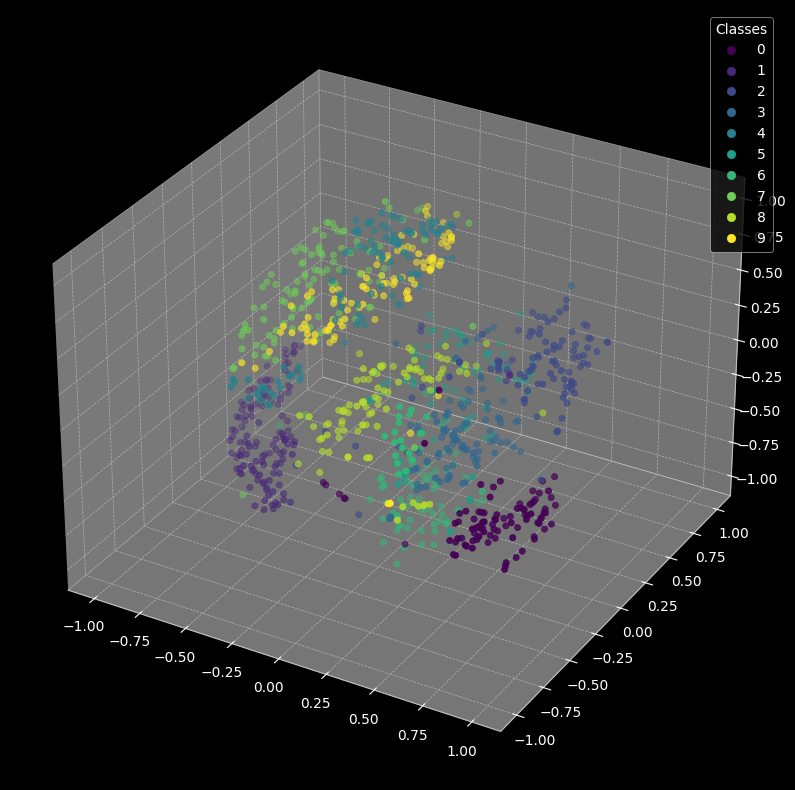

In [21]:
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne_3d[:, 0]
ty = tsne_3d[:, 1]
tz = tsne_3d[:, 2]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)
tz = scale_to_01_range(tz)

tsne_3d[:, 0] = tx
tsne_3d[:, 1] = ty
tsne_3d[:, 2] = tz

fig = plt.figure()
ax = plt.axes(projection='3d')
scatter = ax.scatter3D(tsne_3d[:,0], tsne_3d[:,1], tsne_3d[:,2], c=target.numpy())
plt.legend(*scatter.legend_elements(), title="Classes")

In [ ]:
# Ex1: Train Autoencoder for super resolution: upsampling MNIST images from 7x7 (or 14x14) to 28x28
# SUGGESTION: use torch.nn.functional.interpolate to resize input images